# Machine Learning Project Work

## Task Description

This project is about tackling the Kaggle competition **"Santander Customer Transaction Prediction - Can you identify who will make a transaction?"** (https://www.kaggle.com/competitions/santander-customer-transaction-prediction/overview)

I'll report below the description of the **task**:

"At Santander our mission is to help people and businesses prosper. We are always looking for ways to help our customers understand their financial health and identify which products and services might help them achieve their monetary goals.

Our data science team is continually challenging our machine learning algorithms, working with the global data science community to make sure we can more accurately identify new ways to solve our most common challenge, **binary classification** problems such as: is a customer satisfied? Will a customer buy this product? Can a customer pay this loan?

In this challenge, we invite Kagglers to help us **identify which customers will make a specific transaction in the future**, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem."

As we can see, the task is about a common problem nowdays: predicting the future behaviour of customers. In particular, in this case we're facing a binary classification problem, in which the goal is to build a model able to predict whether a customer will make a certain transaction or not.


## Operating environment
All the experiements have been done in a Jupyter notebook using the local CPU. The classification and evaluation are done using the sklearn and imblearn libraries (the latter for implementing the algorithms for unbalanced data).

### Libraries and modules

In [1]:
# Import the libraries necessary for the task

import opendatasets
import pandas as pd
import json
import requests
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pickle


random_state = 1
#random.seed(random_state)
#np.random.seed(random_state)

## Data

### Load data

In [2]:
opendatasets.download('https://www.kaggle.com/competitions/santander-customer-transaction-prediction/data')

100%|███████████████████████████████████████████████████████████████████████████████| 250M/250M [02:17<00:00, 1.91MB/s]



Extracting archive .\santander-customer-transaction-prediction/santander-customer-transaction-prediction.zip to .\santander-customer-transaction-prediction


### Data exploration

First of all, let's have a look at the dataset provided for this task.

( The Kaggle competition provides two datasets: train.csv and test.csv. Since the test one doesn't have the target variable (so it won't be possible to compute the final metrics on it) I'll just use the train dataset and extract a test set )

In [2]:
# at the end of the project consider to put the dataset on github (tar extension maybe and unzip it?) and load it from it

# Load the dataset and print its shape

df = pd.read_csv("./santander-customer-transaction-prediction/train.csv")

print(df.shape)

(200000, 202)


In [6]:
# Observe the structure of the dataset using the first 5 instances

df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [15]:
null_rows = df[df.isnull().any(axis = 1)]

print('There are ' + str(len(null_rows)) + ' rows with missing values.')

There are 0 rows with missing values.


In [16]:
# Let's check the values for our target

df['target'].unique()

array([0, 1])

In [17]:
# Let's see the type of the features we're dealing with

df.dtypes

ID_code     object
target       int64
var_0      float64
var_1      float64
var_2      float64
            ...   
var_195    float64
var_196    float64
var_197    float64
var_198    float64
var_199    float64
Length: 202, dtype: object

In [18]:
# The majority of them are float64: let's confirm that just the first 2 are different

df.dtypes[df.dtypes != 'float64']

ID_code    object
target      int64
dtype: object

The dataset is composed by 200000 instances: each one is characterized by 202 features and **none of them has missing values**.

Each instance represents a customer transaction, which is identified by the first feature, an ID code.

The next feature is the target variable. As anticipated in the task description, we're facing a binary classification problem: the only values for our target are in fact 0 (the customer won't make the transaction) and 1 (the customer will make the transaction).

Then, we have 200 anonymized numerical features (in particular, floating point numbers): these will be the predictors for the target.

In [3]:
# predictors
X = df.drop(['ID_code','target'], axis = 1)

# target variable
y = df['target']

In [4]:
# split in train and test data

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state = random_state)
print(X_train_val.shape, X_test.shape, y_train_val.shape, y_test.shape)

(150000, 200) (50000, 200) (150000,) (50000,)


In [5]:
# split in train and validation

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state = random_state, test_size = 0.1)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(135000, 200) (15000, 200) (135000,) (15000,)


In [22]:
# number of instances belonging to class 0 and 1
n_0, n_1 = np.bincount(y_train)

# total number of instances
n_tot = n_0 + n_1

# percentage of instances from each class over the total
perc_0 = n_0/n_tot
perc_1 = n_1/n_tot

print('Number of instances belonging to class 0: ' + str(n_0) + ' (' + str(perc_0) + '%' + ')' )
print('Number of instances belonging to class 1: ' + str(n_1) + ' (' + str(perc_1) + '%' + ')' )

Number of instances belonging to class 0: 121366 (0.8990074074074074%)
Number of instances belonging to class 1: 13634 (0.10099259259259259%)


An important aspect that we can notice is that we're facing an **imbalanced dataset**: in fact, there are far more instances belonging to class 0 (almost 90%) with respect to those belonging to class 1 (just 10%).

This is clear observing the plot below that shows the number of instances belonging to each class.

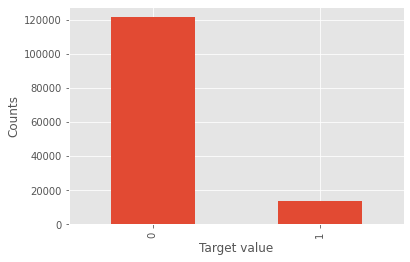

In [23]:
y_train.value_counts().plot(kind = 'bar', xlabel = 'Target value', ylabel = 'Counts')

Let's now check if there are any relevant correlations (> 0.5) between the predictors.

In [ ]:
correlations = X_train.corr().abs()

corr_not_self = correlations[correlations < 1] # get rid of the values of the correlation between a variable and itself

corr_not_self[corr_not_self > 0.5].notna().any().any() 

False

We observe that **there isn't any relevant correlation** between the predictors.

We notice the same thing even if we lower the threshlod to just 0.1.

In [ ]:
correlations = X.corr().abs()

corr_not_self = correlations[correlations < 1]

corr_not_self[corr_not_self > 0.1].notna().any().any() 

False

## Methods

I approached the problem focusing first on the right 'configuration' of the data.

As we noticed before, the data are imbalanced, so it's necessary to use sampling techniques to obtain a more similar distribution of the two classes.

Moreover, we can also notice a high dimensionality, so it's useful to explore which are the relevant features for the task; an alternative could be to apply some dimensionality reduction technique.

I decided to choose one model, the logistic regression, in order to evaluate the performances after applying the techniques that could solve the previously enlisted problems: the ones that will perform better are going to be used to obtain the data on which more models will be trained and tested. 

The choice of the logistic regression for the base model was based on these aspects:
- The 'class_weight' parameter can be set to adjust weights inversely proportional to class frequencies in the input data: this way we can have a good baseline before applying any sampling technique;


- It's not hard to tune: as it's reported on the sklearn documentation, the solvers suited for larger datasets are just the 'sag' and 'saga' ones. Since the 'saga' solver is compatible with more penalty option, we can just set the model to it and explore which is the best configuration for 'penalty';


- Other models could require more time to be properly tuned, so it's better to just try them on the final dataset instead of using them in this first phase.

The measure that will be used is the F1 score, since with unbalanced data the accuracy isn't reliable. In particular, I'll use the default settings of the sklearn function, which return the score for label 1: doing this, I'm focusing on the configuration that works best for the less representative class, whose instances are harder to classify.

In [ ]:
final_results = {} # the dictionary will store the results for the final summary at the end of the notebook

### Baseline

Let's start by adapting the logistic regression on the original data.
I'm going to explore which is the best configuration for penalty using the results on the validation set (cross-validation seemed to require lots of time with this dataset).


Before this, I'll use the Standard Scaler, which operates by removing the mean and scaling the features to unit variance.

In [14]:
# Scale the data

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
results = {}

penalty_params = ['none', 'l1', 'l2']

for penalty in penalty_params:
    
    logistic_reg = LogisticRegression(random_state = random_state, penalty = penalty,
                                      class_weight = 'balanced', solver = 'saga')
    
    # fit model
    logistic_reg.fit(X_train_scaled, y_train)
    
    # predict on training set
    y_train_pred = logistic_reg.predict(X_train_scaled)
    
    # predict on validation set
    y_val_pred = logistic_reg.predict(X_val_scaled)
    
    # store f1 score
    results[penalty] = [f1_score(y_train_pred, y_train), f1_score(y_val_pred, y_val)]
    

In [ ]:
for penalty in results:
    print(penalty) 
    print('F1 on train: ' + str(results[penalty][0]))
    print('F1 on validation: ' + str(results[penalty][1]))
    print()

none
F1 on train: 0.4203451479629154
F1 on validation: 0.4202513719242344

l1
F1 on train: 0.4204325307397304
F1 on validation: 0.4202513719242344

l2
F1 on train: 0.4203534574783538
F1 on validation: 0.4202513719242344



We can observe that there is no real difference between these. We can go on with L2 penalty in the following tests.

In [ ]:
# store the results
final_results['Logistic regression baseline'] = results['l2'][1]

### Reduce number of features

As I'll explain later, sampling methods to overcome the problem of imbalance are based on the distance between the instances. Since our data present a high dimensionality, this could have a negative impact (curse of dimensionality).

So I'll start from trying to reduce the number of features: this could not only be beneficial for the sampling algorithms which will be tested later, but also it could already improve the performance achieved with the baseline model.

There are two possible ways to approach this part: feature selection and dimensionality reduction.


#### Feature selection

Let's start with feature selection. This approach is about selecting which are the features, between the original ones, that are most relevant for our task.

One simple way to do this is looking at the **correlations** between the original features. When we see two features that are highly correlated, we can just pick one between them, since they will have almost the same effect on the target variable.
However, we've already seen that there are no relevant correlations between the predictors, so we can't rely on this.

Our first try will be using the **ANOVA** statistical test, which evaluates the linear relationship between continuos predictors and a categorical target.

In [ ]:
n_features = range(10, 171, 20) 
# number of features: since we have 200 features, 
# I'll test anova with min 10
# and max 170 features (since we want to reduce the number of features, there's no need to test with more)
# with a step of 20 (to have a shorter running time)

results = {}

for k in n_features:
    
    # features selection
    anova = SelectKBest(score_func = f_classif, k = k)
    anova.fit(X_train_scaled, y_train)
    
    X_train_k_best = anova.transform(X_train_scaled)
    X_val_k_best = anova.transform(X_val_scaled)
    
    # initialize model
    logistic_reg = LogisticRegression(random_state = random_state, penalty = 'l2',
                                      class_weight = 'balanced', solver = 'saga')
    
    # fit model
    logistic_reg.fit(X_train_k_best, y_train)
    
    # predict on training set
    y_train_pred = logistic_reg.predict(X_train_k_best)
    
    # predict on validation set
    y_val_pred = logistic_reg.predict(X_val_k_best)
    
    # store f1 score
    results[k] = [f1_score(y_train_pred, y_train), f1_score(y_val_pred, y_val)]

In [ ]:
for k in results:
    print('Number of features: ' + str(k))
    print('F1 on train: ' + str(results[k][0]))
    print('F1 on validation: ' + str(results[k][1]))
    print()

Number of features: 10
F1 on train: 0.26250835917077026
F1 on validation: 0.2578188740821322

Number of features: 30
F1 on train: 0.3195404636030907
F1 on validation: 0.3255956017104459

Number of features: 50
F1 on train: 0.35430070809819914
F1 on validation: 0.3608660785886127

Number of features: 70
F1 on train: 0.37867393211039985
F1 on validation: 0.3821571238348868

Number of features: 90
F1 on train: 0.39536127775018143
F1 on validation: 0.39480782198246794

Number of features: 110
F1 on train: 0.40676782180138926
F1 on validation: 0.4068787618228719

Number of features: 130
F1 on train: 0.41353824495541996
F1 on validation: 0.41288741026090003

Number of features: 150
F1 on train: 0.418491004748862
F1 on validation: 0.4201799259128594

Number of features: 170
F1 on train: 0.4201508152710333
F1 on validation: 0.41984056687333926



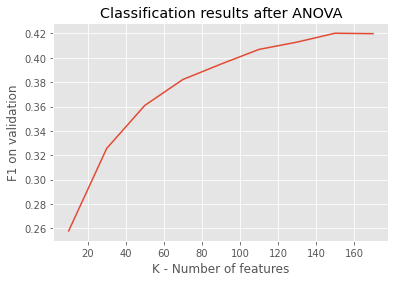

In [ ]:
# plot f1 on validation

f1_on_validation = [results[k][1] for k in results]

plt.plot(n_features, f1_on_validation)
plt.xlabel('K - Number of features')
plt.ylabel('F1 on validation')
plt.title('Classification results after ANOVA')
  
# function to show the plot
plt.show()

We can observe that the performances clearly increase with with the number of features: however, with already 150 predictors the classifier achieves the same results obtained with 200; moreover, the F1 score remains almost the same with 170.

In [ ]:
final_results['Logistic regression with ANOVA - 150 features'] = results[150][1]

Another statistical test that can be used for feature selection is **Mutual Information**: the advantage that this have with respect to ANOVA is that it works well with non-linear relationships between features and target variable.

In [ ]:
n_features = [50, 100, 130, 150, 170] # mutual info is slower wrt ANOVA: try less values for k
results = {}

for k in n_features:
    
    # features selection
    mutual_info = SelectKBest(score_func = mutual_info_classif, k = k)
    mutual_info.fit(X_train_scaled, y_train)
    
    X_train_k_best = mutual_info.transform(X_train_scaled)
    X_val_k_best = mutual_info.transform(X_val_scaled)
    
    # initialize model
    logistic_reg = LogisticRegression(random_state = random_state, penalty = 'l2',
                                      class_weight = 'balanced', solver = 'saga')
    
    # fit model
    logistic_reg.fit(X_train_k_best, y_train)
    
    # predict on training set
    y_train_pred = logistic_reg.predict(X_train_k_best)
    
    # predict on validation set
    y_val_pred = logistic_reg.predict(X_val_k_best)
    
    # store f1 score
    results[k] = [f1_score(y_train_pred, y_train), f1_score(y_val_pred, y_val)]

In [ ]:
for k in results:
    print('Number of features: ' + str(k))
    print('F1 on train: ' + str(results[k][0]))
    print('F1 on validation: ' + str(results[k][1]))
    print()

Number of features: 50
F1 on train: 0.34091227578475336
F1 on validation: 0.3414634146341463

Number of features: 100
F1 on train: 0.3865698387248892
F1 on validation: 0.3846284069747757

Number of features: 130
F1 on train: 0.3972996816386023
F1 on validation: 0.3973260198834419

Number of features: 150
F1 on train: 0.40689427355575847
F1 on validation: 0.402081526452732

Number of features: 170
F1 on train: 0.4128320056370007
F1 on validation: 0.41109932838458824



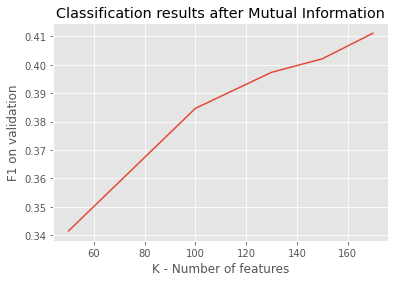

In [ ]:
# plot f1 on validation

f1_on_validation = [results[k][1] for k in results]

plt.plot(n_features, f1_on_validation)
plt.xlabel('K - Number of features')
plt.ylabel('F1 on validation')
plt.title('Classification results after Mutual Information')
  
# function to show the plot
plt.show()

The best performances are achieved with 170 features: however, the results obtained with the predictors selected with ANOVA were a bit better with respect to the ones with Mutual Information.

In [ ]:
final_results['Logistic regression with Mutual Info - 170 features'] = results[170][1]

The last technique that I'm going to try for feature selection is the one based on **Decision Trees**, in particular **Random Forests**. Tree based models calculate **feature importance** in order to keep the best performing features close to the root of the tree.
We can use this feature importance to select the features to keep and the ones to drop.

In [ ]:
forest_selector = SelectFromModel(RandomForestClassifier(random_state = random_state))
forest_selector.fit(X_train_scaled, y_train)

SelectFromModel(estimator=RandomForestClassifier(random_state=1))

In [ ]:
# convert to df to select columns easily
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns = X_val.columns)

selected_feat = X_train_scaled_df.columns[(forest_selector.get_support())]

# sel.get_support() is a 1D array of boolean values having dimension equal to the number of features:
# TRUE is the value assigned to the features to keep;
# FALSE is the value assigned to the features to drop.

print('Number of features selected: ' + str(len(selected_feat)))

Number of features selected: 71


In [ ]:
# predictors after feature selection (fs)

X_train_scaled_fs = X_train_scaled_df[selected_feat]
X_val_scaled_fs = X_val_scaled_df[selected_feat]

In [ ]:
# classification with logistic regression using the selected features

# initialize model
logistic_reg = LogisticRegression(random_state = random_state, penalty = 'l2',
                                      class_weight = 'balanced', solver = 'saga')
    
# fit model
logistic_reg.fit(X_train_scaled_fs, y_train)

# predict on training set
y_train_pred = logistic_reg.predict(X_train_scaled_fs)

# predict on validation set
y_val_pred = logistic_reg.predict(X_val_scaled_fs)

In [ ]:
# f1 score
print('F1 on train: ' + str(f1_score(y_train_pred, y_train)))
print('F1 on train: ' + str(f1_score(y_val_pred, y_val)))

F1 on train: 0.37690635855330373
F1 on train: 0.37758307158207965


In [ ]:
final_results['Logistic regression with Random Forests Feat. Sel.'] = f1_score(y_val_pred, y_val)

We can conclude that ANOVA provide the selection of features that perform best in the classification task on the dataset.

#### Dimensionality reduction

I'll try now to reduce the number of features with dimensionality reduction: with respect to feature selection, dimensionality reduction **transforms** the original features into new ones.

The method that I'm going to use is **Principal Component Analysis (PCA)**. PCA creates linear combinations from the original features: these combinations are done in such a way that the new variables (i.e., principal components) are uncorrelated and most of the information within the initial variables is squeezed or compressed into the first components (they account for most of the variance of the dataset). These will be the ones that we're going to select.

In [ ]:
# initialize PCA with 0.95 as the amount of variance that needs to be explained
pca = PCA(n_components = 0.95, random_state = random_state)

# fit on data
pca.fit(X_train_scaled)

PCA(n_components=0.95, random_state=1)

In [ ]:
# reduced data
X_train_scaled_reduced = pca.transform(X_train_scaled)
X_val_scaled_reduced = pca.transform(X_val_scaled)

print('Number of features after PCA with 0.95: ' + str(X_train_scaled_reduced.shape[1]))

Number of features after PCA with 0.95: 190


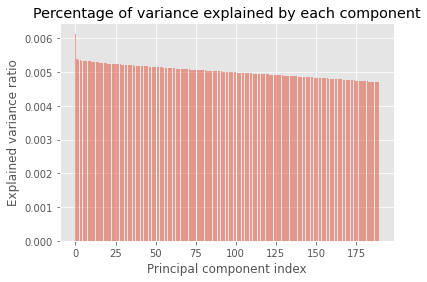

In [ ]:
# Percentage of variance explained by each of the selected components
explained_var_pca = pca.explained_variance_ratio_

# plot
plt.bar(range(0,len(explained_var_pca)), explained_var_pca, alpha = 0.5, align='center')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Percentage of variance explained by each component')
plt.show()

The number of features after PCA still remains pretty high. In fact, we can see that in the graph that the percentage of variance explained by each component is pretty low.

In [ ]:
# classification with logistic regression using the reduced dataset

# initialize model
logistic_reg = LogisticRegression(random_state = random_state, penalty = 'l2',
                                      class_weight = 'balanced', solver = 'saga')
    
# fit model
logistic_reg.fit(X_train_scaled_reduced, y_train)

# predict on training set
y_train_pred = logistic_reg.predict(X_train_scaled_reduced)

# predict on validation set
y_val_pred = logistic_reg.predict(X_val_scaled_reduced)

In [ ]:
# f1 score
print('F1 on train: ' + str(f1_score(y_train_pred, y_train)))
print('F1 on train: ' + str(f1_score(y_val_pred, y_val)))

F1 on train: 0.4199668010433958
F1 on train: 0.4206798866855525


In [ ]:
final_results['Logistic Regression with PCA - 0.95'] = f1_score(y_val_pred, y_val)

Let's try also with 0.90 as the percentage of exmplained variance.

Number of features after PCA with 0.90: 179


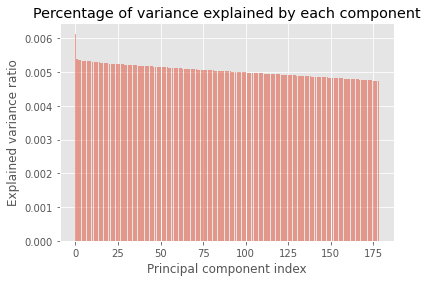

In [ ]:
pca = PCA(n_components = 0.90, random_state = random_state)

# fit on data
pca.fit(X_train_scaled)

# reduced data
X_train_scaled_reduced = pca.transform(X_train_scaled)
X_val_scaled_reduced = pca.transform(X_val_scaled)

print('Number of features after PCA with 0.90: ' + str(X_train_scaled_reduced.shape[1]))

# Percentage of variance explained by each of the selected components
explained_var_pca = pca.explained_variance_ratio_

# plot
plt.bar(range(0,len(explained_var_pca)), explained_var_pca, alpha = 0.5, align='center')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Percentage of variance explained by each component')
plt.show()

The number of features doesn't change much.

In [ ]:
# classification with logistic regression using the reduced dataset

# initialize model
logistic_reg = LogisticRegression(random_state = random_state, penalty = 'l2',
                                      class_weight = 'balanced', solver = 'saga')
    
# fit model
logistic_reg.fit(X_train_scaled_reduced, y_train)

# predict on training set
y_train_pred = logistic_reg.predict(X_train_scaled_reduced)

# predict on validation set
y_val_pred = logistic_reg.predict(X_val_scaled_reduced)

# f1 score
print('F1 on train: ' + str(f1_score(y_train_pred, y_train)))
print('F1 on train: ' + str(f1_score(y_val_pred, y_val)))

F1 on train: 0.41982081540829613
F1 on train: 0.4201204392490258


With fewer features the results get slightly better and meet the best performance obtained previously with other methods.

In [ ]:
final_results['Logistic Regression with PCA - 0.90'] = f1_score(y_val_pred, y_val)

#### Reduce number of features - Conclusion

In this section we have observed that, using a subset of features, we can achieve the same performance obtained with all the features: in particular, this happend with PCA and ANOVA.

Although, in the case of PCA, we don't have a great reduction in the number of predictors (179 vs the original 200). On the other hand, the situation is a bit better when using ANOVA, that allows us to select 150 features, so 50 less with respect to the initial ones.

### Sampling algorithms for unbalanced data

A common strategy to tackle the problem of class imbalance is trying to restore a more even distrubution between the classes. For this purpose, we can use **sampling algorithms**. We can divide them in two categories: **undersampling** and **oversampling**.

- With undersampling, we delete instances from the over-represented class;

- With oversampling, we add copies of instances from the under-represented class.

Let's start with undersampling, for which I'm going to try the **Near Miss** algorithm.

#### Undersampling - Near Miss

Near Miss belongs to a family of methods that choose which examples from the majority class to keep. In particular, it selects examples based on the distance of majority class examples to minority class examples. There are three versions of the algorithm: I'm going to use the first, which is the default one in the imbalanced-learn function.

- NearMiss-1 selects examples from the majority class that have the smallest average distance to the three closest examples from the minority class

The distance used is the Euclidean distance.

In [ ]:
# undersamplig with Near Miss

print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0)))


# initialize near miss from imbalanced-learn library
near_miss = NearMiss()
  
X_train_miss, y_train_miss = near_miss.fit_resample(X_train_scaled, y_train.ravel())
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape))
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1)))
print("After Undersampling, counts of label '0': {} \n".format(sum(y_train_miss == 0)))

# initialize model
logistic_reg = LogisticRegression(random_state = random_state, penalty = 'l2',
                                  class_weight = 'balanced', solver = 'saga')

logistic_reg.fit(X_train_miss, y_train_miss)

y_train_pred = logistic_reg.predict(X_train_miss)
print('F1 on train: ' + str(f1_score(y_train_pred, y_train_miss)))


y_val_pred = logistic_reg.predict(X_val_scaled)
print('F1 on val: ' + str(f1_score(y_val_pred, y_val)))

Before Undersampling, counts of label '1': 13634
Before Undersampling, counts of label '0': 121366 

After Undersampling, the shape of train_X: (27268, 200)
After Undersampling, the shape of train_y: (27268,) 

After Undersampling, counts of label '1': 13634
After Undersampling, counts of label '0': 13634 

F1 on train: 0.7574728762270277
F1 on val: 0.42921180425849836


Using the data after undersampling, we achieve the best results obtained so far on the validation set.

In [ ]:
final_results['Logistic regression with Near Miss'] = f1_score(y_val_pred, y_val)

#### Oversampling - SMOTE

For oversampling, I'll try the **SMOTE** algorithm.
It consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbours.

In [ ]:
# oversampling with SMOTE

print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# initialize smote from imbalanced-learn library
smote = SMOTE(random_state = random_state)

X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled, y_train.ravel())
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_sm.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_sm == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_sm == 0)))

# initialize model
logistic_reg = LogisticRegression(random_state = random_state, penalty = 'l2',
                                  class_weight = 'balanced', solver = 'saga')

logistic_reg.fit(X_train_sm, y_train_sm)

y_train_pred = logistic_reg.predict(X_train_sm)
print('F1 on train: ' + str(f1_score(y_train_pred, y_train_sm)))

y_val_pred = logistic_reg.predict(X_val_scaled)
print('F1 on val: ' + str(f1_score(y_val_pred, y_val)))

Before OverSampling, counts of label '1': 13634
Before OverSampling, counts of label '0': 121366 

After OverSampling, the shape of train_X: (242732, 200)
After OverSampling, the shape of train_y: (242732,) 

After OverSampling, counts of label '1': 121366
After OverSampling, counts of label '0': 121366 

F1 on train: 0.8037250510909604
F1 on val: 0.42231947483588617


After oversampling, the results are a bit worse than after undersampling: still, we achieve a better result with respect to the ones obtained before the sampling algorithms.

In [ ]:
final_results['Logistic regression with SMOTE'] = f1_score(y_val_pred, y_val)

#### Combination of undersampling and oversampling

Let's try also a combination of under and oversampling. In particular, we'll use SMOTETomek, which consists of over-sampling using SMOTE and cleaning using Tomek links. 

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.
(I've used Near Miss instead of Tomek links in the undersample part because Tomek Links aren't very effective alone https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/)

In [ ]:
# sampling combination

print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
# initialize smote from imbalanced-learn library    
smote_tom = SMOTETomek(random_state = random_state)

X_train_st, y_train_st = smote_tom.fit_resample(X_train_scaled, y_train.ravel())
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_st.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_st.shape))
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_st == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(y_train_st == 0)))

Before Undersampling, counts of label '1': 13634
Before Undersampling, counts of label '0': 121366 

After Undersampling, the shape of train_X: (242732, 200)
After Undersampling, the shape of train_y: (242732,) 

After Undersampling, counts of label '1': 121366
After Undersampling, counts of label '0': 121366


In [ ]:
# initialize model
logistic_reg = LogisticRegression(random_state = random_state, penalty = 'l2',
                                  class_weight = 'balanced', solver = 'saga')

logistic_reg.fit(X_train_st, y_train_st)

y_train_pred = logistic_reg.predict(X_train_st)
print('F1 on train: ' + str(f1_score(y_train_pred, y_train_st)))

y_val_pred = logistic_reg.predict(X_val_scaled)
print('F1 on val: ' + str(f1_score(y_val_pred, y_val)))

F1 on train: 0.8037250510909604
F1 on val: 0.42231947483588617


In [ ]:
final_results['Logistic regression with SMOTETomek'] = f1_score(y_val_pred, y_val)

We observe the same results, in terms of sampled data and F1 score, obtained with just SMOTE.

#### Sampling algorithms using reduced data

My next try will be using these sampling algorithms on the data with less features. Since they are based on the Euclidean distance, the curse of dimensionality could play a negative role in the capacity of the distance measure to effectively express the difference between instances.

We observed before that ANOVA allowed to reduce to 150 the number of features and obtaining the same scores obtained with all the features: I'm going to use the features obtained this way and try again the sampling algorithms seen before.

In [ ]:
# features selection

# number of features
k = 150

anova = SelectKBest(score_func = f_classif, k = k)
anova.fit(X_train_scaled, y_train)

X_train_k_best = anova.transform(X_train_scaled)
X_val_k_best = anova.transform(X_val_scaled)

In [ ]:
# undersamplig with Near Miss

print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0)))


# initialize near miss from imbalanced-learn library
near_miss = NearMiss()
  
X_train_miss, y_train_miss = near_miss.fit_resample(X_train_k_best, y_train.ravel())
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape))
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1)))
print("After Undersampling, counts of label '0': {} \n".format(sum(y_train_miss == 0)))

# initialize model
logistic_reg = LogisticRegression(random_state = random_state, penalty = 'l2',
                                  class_weight = 'balanced', solver = 'saga')

logistic_reg.fit(X_train_miss, y_train_miss)

y_train_pred = logistic_reg.predict(X_train_miss)
print('F1 on train: ' + str(f1_score(y_train_pred, y_train_miss)))


y_val_pred = logistic_reg.predict(X_val_k_best)
print('F1 on val: ' + str(f1_score(y_val_pred, y_val)))

Before Undersampling, counts of label '1': 13634
Before Undersampling, counts of label '0': 121366 

After Undersampling, the shape of train_X: (27268, 150)
After Undersampling, the shape of train_y: (27268,) 

After Undersampling, counts of label '1': 13634
After Undersampling, counts of label '0': 13634 

F1 on train: 0.7517447657028914
F1 on val: 0.4302413273001508


The results are just a bit better than the ones obtained using all the features.

In [ ]:
final_results['Logistic regression with ANOVA and Near Miss'] = f1_score(y_val_pred, y_val)

In [ ]:
# oversampling with SMOTE

print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# initialize smote from imbalanced-learn library
smote = SMOTE(random_state = random_state)

X_train_sm, y_train_sm = smote.fit_resample(X_train_k_best, y_train.ravel())
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_sm.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_sm == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_sm == 0)))

# initialize model
logistic_reg = LogisticRegression(random_state = random_state, penalty = 'l2',
                                  class_weight = 'balanced', solver = 'saga')

logistic_reg.fit(X_train_sm, y_train_sm)

y_train_pred = logistic_reg.predict(X_train_sm)
print('F1 on train: ' + str(f1_score(y_train_pred, y_train_sm)))

y_val_pred = logistic_reg.predict(X_val_k_best)
print('F1 on val: ' + str(f1_score(y_val_pred, y_val)))

Before OverSampling, counts of label '1': 13634
Before OverSampling, counts of label '0': 121366 

After OverSampling, the shape of train_X: (242732, 150)
After OverSampling, the shape of train_y: (242732,) 

After OverSampling, counts of label '1': 121366
After OverSampling, counts of label '0': 121366 

F1 on train: 0.8021233515711254
F1 on val: 0.4205035971223021


In the case of oversampling the F1 score doesn't improve with respect to using all the features.

In [ ]:
final_results['Logistic regression with ANOVA and SMOTE'] = f1_score(y_val_pred, y_val)

In [ ]:
# sampling combination

print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
# initialize smote from imbalanced-learn library    
smote_tom = SMOTETomek(random_state = random_state)

X_train_st, y_train_st = smote_tom.fit_resample(X_train_k_best, y_train.ravel())
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_st.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_st.shape))
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_st == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(y_train_st == 0)))

Before Undersampling, counts of label '1': 13634
Before Undersampling, counts of label '0': 121366 

After Undersampling, the shape of train_X: (242732, 150)
After Undersampling, the shape of train_y: (242732,) 

After Undersampling, counts of label '1': 121366
After Undersampling, counts of label '0': 121366


In [ ]:
# initialize model
logistic_reg = LogisticRegression(random_state = random_state, penalty = 'l2',
                                  class_weight = 'balanced', solver = 'saga')

logistic_reg.fit(X_train_st, y_train_st)

y_train_pred = logistic_reg.predict(X_train_st)
print('F1 on train: ' + str(f1_score(y_train_pred, y_train_st)))

y_val_pred = logistic_reg.predict(X_val_k_best)
print('F1 on val: ' + str(f1_score(y_val_pred, y_val)))

F1 on train: 0.8021233515711254
F1 on val: 0.4205035971223021


Again, when using a combination of under and over sampling, the results are the same as the ones obtained with just oversampling.

In [ ]:
final_results['Logistic regression with ANOVA and SMOTETomek'] = f1_score(y_val_pred, y_val)

#### Sampling algorithms for unbalanced data - Conclusions

We observed that, when using Near Miss and the features from ANOVA, the F1 score reaches the best values observed so far. I'm going to proceed with this configuration of the dataset to explore other classification models in the next section.

### Other models

In [ ]:
# recreate the optimal dataset

# features selection

# number of features
k = 150

anova = SelectKBest(score_func = f_classif, k = k)
anova.fit(X_train_scaled, y_train)

X_train_k_best = anova.transform(X_train_scaled)
X_val_k_best = anova.transform(X_val_scaled)


# undersampling
near_miss = NearMiss()
  
X_train_miss, y_train_miss = near_miss.fit_resample(X_train_k_best, y_train.ravel())

#### Decision Tree

Let's start with Decision Trees. For this model, I'll tune the max depth parameter. Let's fit first the non-tuned model to have an upper bound for the depth.

In [ ]:
decision_tree = DecisionTreeClassifier(random_state = random_state, criterion = 'entropy')
decision_tree.fit(X_train_miss, y_train_miss)

max_depth = decision_tree.tree_.max_depth
print('Decision Tree max depth: ' + str(max_depth))

Decision Tree max depth: 44


In [ ]:
# tune the decision tree

results = {}
depths = range(1, max_depth, 5)

for d in depths:
    
    # initialize and fit the model
    decision_tree = DecisionTreeClassifier(random_state = random_state, criterion = 'entropy', max_depth = d)
    decision_tree.fit(X_train_miss, y_train_miss)
    
    # predict
    y_train_pred = decision_tree.predict(X_train_miss)
    y_val_pred = decision_tree.predict(X_val_k_best)
    
    # store results
    results[d] = [f1_score(y_train_pred, y_train_miss), f1_score(y_val_pred, y_val)]

In [ ]:
for d in results:
    print('Depth: ' + str(d))
    print('F1 on train: ' + str(results[d][0]))
    print('F1 on validation: ' + str(results[d][1]) + '\n')

Depth: 1
F1 on train: 0.29018275538894095
F1 on validation: 0.19710729902455432

Depth: 6
F1 on train: 0.6394874337363182
F1 on validation: 0.24177872453734522

Depth: 11
F1 on train: 0.6526486049332795
F1 on validation: 0.2727095135768705

Depth: 16
F1 on train: 0.79559049735088
F1 on validation: 0.2699237699237699

Depth: 21
F1 on train: 0.899768758472211
F1 on validation: 0.26511009309886213

Depth: 26
F1 on train: 0.960291273182387
F1 on validation: 0.25089415816664457

Depth: 31
F1 on train: 0.9866874327882226
F1 on validation: 0.24216702034702284

Depth: 36
F1 on train: 0.9966887417218544
F1 on validation: 0.23776739611507253

Depth: 41
F1 on train: 0.9994130594277331
F1 on validation: 0.236083984375



The best score is obtained is a depth equal to 11: still, the results are way worse with respect to the ones observed with logistic regression.

In [ ]:
max_depth = 11

In [ ]:
final_results['Decision Tree with ANOVA and Near Miss'] = results[max_depth][1]

#### Random Forests

Let's try now with Random Forests. In this case I'll tune the number of estimators and I'll use the best depth found before as max depth.

In [ ]:
results = {}
n_estimators = [100, 200, 300]

for n in n_estimators:

    # initialize and fit model
    rand_forest = RandomForestClassifier(random_state = random_state, criterion = 'entropy', 
                                       max_depth = max_depth, n_estimators = n)

    rand_forest.fit(X_train_miss, y_train_miss)
    
    # predict
    y_train_pred = rand_forest.predict(X_train_miss)
    y_val_pred = rand_forest.predict(X_val_k_best)
    
    # store results
    results[n] = [f1_score(y_train_pred, y_train_miss), f1_score(y_val_pred, y_val)]

In [ ]:
for n in results:
    print('# estimators: ' + str(n))
    print('F1 on train: ' + str(results[n][0]))
    print('F1 on validation: ' + str(results[n][1]) + '\n')

# estimators: 100
F1 on train: 0.8824838991810448
F1 on validation: 0.3364737550471063

# estimators: 200
F1 on train: 0.890436582162614
F1 on validation: 0.34223956769738817

# estimators: 300
F1 on train: 0.8914731769485046
F1 on validation: 0.34310629980454066



The performances are pretty much the same regardless of the number of estimators: with 300 they are marginally better but, as we observed with decision trees, the scores aren't close to the ones obtained with logistic regression.

In [ ]:
final_results['Random Forests with ANOVA and Near Miss'] = results[300][1]

The last models that I'm going to try are Naive Bayes and Support Vector Machines.

#### Naive Bayes

In [ ]:
# initialize and fit the model
gnb = GaussianNB()
gnb.fit(X_train_miss, y_train_miss)

GaussianNB()

In [ ]:
y_train_pred = gnb.predict(X_train_miss)
print('F1 on train: ' + str(f1_score(y_train_pred, y_train_miss)))

y_val_pred = gnb.predict(X_val_k_best)
print('F1 on validation: ' + str(f1_score(y_val_pred, y_val)))

F1 on train: 0.9239432389819054
F1 on validation: 0.3093607305936073


In [ ]:
final_results['Naive Bayes with ANOVA and Near Miss'] = f1_score(y_val_pred, y_val)

#### Support Vector Machines

In [ ]:
# initialize and fit the model
svc = SVC(random_state = random_state)
svc.fit(X_train_miss, y_train_miss)

SVC(random_state=1)

In [ ]:
y_train_pred = svc.predict(X_train_miss)
print('F1 on train: ' + str(f1_score(y_train_pred, y_train_miss)))

y_val_pred = svc.predict(X_val_k_best)
print('F1 on validation: ' + str(f1_score(y_val_pred, y_val)))

F1 on train: 0.976111504490739
F1 on validation: 0.2527956003666361


In [ ]:
final_results['Support Vector Machines with ANOVA and Near Miss'] = f1_score(y_val_pred, y_val)

#### Other models - Conclusions

We've seen that using other classifiers doesn't improve the results obtained with logistic regression: in particular, this model provides much better results with respect to the ones tested in this section. 

### Alternative approach - One Class Classification

One last approach that I'll try is treating the problem as **anomaly detection**. In machine learning, to tackle this type of challange, **one class classifiers** are among the options. I'll use the one class version of SVM.

In [ ]:
# to train on majority class
X_train_0 = X_train_scaled[y_train == 0]

In [ ]:
from sklearn.svm import OneClassSVM

# define outlier detection model
one_class_svm = OneClassSVM(nu = 0.2) 

# The nu parameter is both a lower bound for the number of samples that are support vectors and 
# an upper bound for the number of samples that are on the wrong side of the hyperplane

one_class_svm.fit(X_train_0)

# the predict() function will output a +1 for normal examples (inliers) and a -1 for outliers
# detect outliers in the test set
y_val_pred = one_class_svm.predict(X_val_scaled)

# copy y_val to not change the original data
y_val_ = y_val.copy()

# mark inliers 1, outliers -1
y_val_[y_val_ == 1] = -1
y_val_[y_val_ == 0] = 1

In [ ]:
# calculate score
score = f1_score(y_val_, y_val_pred, pos_label = -1)
print('F1 on validation: ' + str(score))

F1 on validation: 0.3021813087852711


Again, the score obtained is not as good as the one obtained with logistic regression.

In [ ]:
final_results['One class approach - SVM'] = score

In [ ]:
# create models, scores dictionary to load it later as pandas df

models = []
scores = []

for model in final_results:
    models.append(model)
    scores.append(final_results[model])
    
final_dict = {}
final_dict['Models'] = models
final_dict['F1 score'] = scores

In [ ]:
# save dictionary with final results

path_dict = "./results/final_results.json"

with open(path_dict, 'w') as fp:
    json.dump(final_dict, fp)

## Final results

In this section I'll summarize the results obtained so far on the validation set: the method that produced the best score will be used on the test set to obtain the final evaluation.

In [22]:
# load dictionary with final results

path_dict = "./results/final_results.json"
  

final_results = pd.read_json(path_dict)
final_results

,Models,F1 score
0,Logistic regression baseline,0.420251
1,Logistic regression with ANOVA - 150 features,0.420180
2,Logistic regression with Mutual Info - 170 fea...,0.411099
3,Logistic regression with Random Forests Feat. ...,0.377583
4,Logistic Regression with PCA - 0.95,0.420680
5,Logistic Regression with PCA - 0.90,0.420120
6,Logistic regression with Near Miss,0.429212
7,Logistic regression with SMOTE,0.422319
8,Logistic regression with SMOTETomek,0.422319
9,Logistic regression with ANOVA and Near Miss,0.430241


As already anticipated, the logistic regression, trained on the training set after ANOVA and Near Miss undersample, was the model that delivered the best performance.

In [11]:
# recreate and save best model

# features selection

# number of features
k = 150

anova = SelectKBest(score_func = f_classif, k = k)
anova.fit(X_train_scaled, y_train)

X_train_k_best = anova.transform(X_train_scaled)
X_val_k_best = anova.transform(X_val_scaled)

# undersampling

# initialize near miss from imbalanced-learn library
near_miss = NearMiss()
  
X_train_miss, y_train_miss = near_miss.fit_resample(X_train_k_best, y_train.ravel())

# initialize model
logistic_reg = LogisticRegression(random_state = random_state, penalty = 'l2',
                                  class_weight = 'balanced', solver = 'saga')

logistic_reg.fit(X_train_miss, y_train_miss)

LogisticRegression(class_weight='balanced', random_state=1, solver='saga')

In [ ]:
# save the model
model_filename = './models/best_model.sav'
pickle.dump(logistic_reg, open(model_filename, 'wb'))

In [12]:
# save ANOVA
anova_filename = './models/anova.sav'
pickle.dump(anova, open(anova_filename, 'wb'))

In [15]:
# save scaler
scaler_filename = './models/scaler.sav'
pickle.dump(scaler, open(scaler_filename, 'wb'))

In [ ]:
# best model classification report on validation
y_val_pred = best_model.predict(X_val_k_best)

print('Validation set: classification report\n')
print(classification_report(y_val, y_val_pred))

Validation set: classification report

              precision    recall  f1-score   support

           0       0.97      0.80      0.88     13479
           1       0.30      0.75      0.43      1521

    accuracy                           0.80     15000
   macro avg       0.63      0.78      0.65     15000
weighted avg       0.90      0.80      0.83     15000



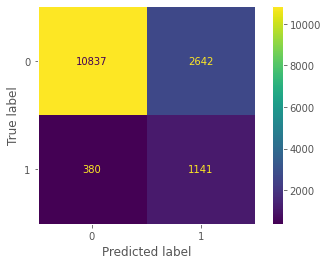

In [ ]:
# best model confusion matrix on validation
cf_matrix_val = confusion_matrix(y_val, y_val_pred)

# plot
fig, _ = plt.subplots(nrows = 1)
ax = plt.subplot(1, 1, 1)
ax.grid(False)

disp = ConfusionMatrixDisplay(cf_matrix_val, display_labels = [0,1])
disp.plot(ax = ax)
plt.show()

### Test set results

Let's now compute the results on the test set

In [16]:
# load
model_filename = './models/best_model.sav'
best_model = pickle.load(open(model_filename, 'rb'))

anova_filename = './models/anova.sav'
anova = pickle.load(open(anova_filename, 'rb'))

scaler_filename = './models/scaler.sav'
scaler = pickle.load(open(scaler_filename, 'rb'))

In [17]:
# prepare test data

# scale data
X_test_scaled = scaler.transform(X_test)

# anova
X_test_k_best = anova.transform(X_test_scaled)

In [19]:
# predictions on test

y_test_pred = best_model.predict(X_test_k_best)

In [20]:
# F1 score on test

f1_score(y_test, y_test_pred)

0.42105263157894746

In [21]:
# classification report on test

print('Test set: classification report\n')
print(classification_report(y_test, y_test_pred))

Test set: classification report

              precision    recall  f1-score   support

           0       0.97      0.80      0.88     45057
           1       0.29      0.74      0.42      4943

    accuracy                           0.80     50000
   macro avg       0.63      0.77      0.65     50000
weighted avg       0.90      0.80      0.83     50000



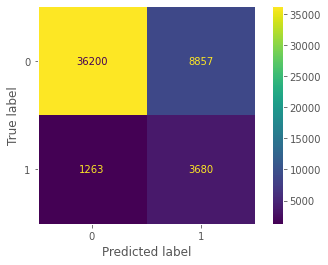

In [ ]:
# confusion matrix on test

# best model confusion matrix on test
cf_matrix_test = confusion_matrix(y_test, y_test_pred)

# plot
fig, _ = plt.subplots(nrows = 1)
ax = plt.subplot(1, 1, 1)
ax.grid(False)

disp = ConfusionMatrixDisplay(cf_matrix_test, display_labels = [0,1])
disp.plot(ax = ax)
plt.show()

## Conclusion

This work was focused on achieving better results in the binary classification task by trying to reduce the impact of the imbalance and the high-dimensionality of the dataset. It was possible to observe some little improvements with respect to the initial results given by the baseline. 

The final scores aren't bad, with an weighted average F1 score of 0.83 on the test set.

However, some future work could improve the score for the less-represented class, which is below 0.5. A couple of possibilities could be:

- a more complex classification model: for example, a neural network with some hidden layers. In this case, the work could be focused on trying to find the best hyperparameters for this model (e.g.: number of hidden layers, activation function, use of dropout, etc.);

- a different solution for the imbalance problem. With undersampling we're throwing away lots of samples and potentially useful information: finding a method that solve the imbalance problem and work on as many instances as possible could improve the results.

## References

Resampling strategies for imbalanced datasets https://www.kaggle.com/code/rafjaa/resampling-strategies-for-imbalanced-datasets/notebook

Undersampling algorithms for imbalanced classification https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/

Smote for Imbalanced Classification in Python https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

One-Class classification for Imbalanced Datasets https://machinelearningmastery.com/one-class-classification-algorithms/